In [1]:
import os
os.environ['PYSPARK_PYTHON'] = '/opt/conda/bin/python'

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
#spark


In [3]:
df = spark.read.format('csv').load("train.csv", header=True)#,multiLine=True)
df.printSchema()

root
 |-- Dates: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: string (nullable = true)
 |-- Y: string (nullable = true)



## First Step: Let's perform 3 EDA Visualization Steps:
#### a- Check Crimes Distribution per each Police Department District.
#### b- Check the Top Committed Crime throughout the years.
#### c- Compute the Total Number of Crimes per year.

In [4]:
df.columns

['Dates',
 'Category',
 'Descript',
 'DayOfWeek',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y']

In [5]:
print((df.count(), len(df.columns)))
df.limit(5).toPandas()

(878049, 9)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.42436302145,37.8004143219856
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.42699532676599,37.80087263276921
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438737622757,37.771541172057795


In [6]:
# Statistical Summary:

df.select(['Dates', 'Category', 'Descript', 'DayOfWeek',
           'PdDistrict', 'Resolution', 'Address', 'X', 'Y']).describe().toPandas()

,summary,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,count,878049,878049,878049,878049,878049,878049,878049,878049,878049
1,mean,None,None,None,None,None,None,None,-122.4226164550638,37.77102029800635
2,stddev,None,None,None,None,None,None,None,0.03035362299848847,0.4568931047058097
3,min,2003-01-06 00:01:00,ARSON,ABANDONMENT OF CHILD,Friday,BAYVIEW,"ARREST, BOOKED",0 Block of HARRISON ST,-120.5,37.7078790224135
4,max,2015-05-13 23:53:00,WEAPON LAWS,YOUTH COURT,Wednesday,TENDERLOIN,UNFOUNDED,ZOE ST / WELSH ST,-122.51364206429,90.0


In [7]:
# 1- Sorting crime categories Per PdDistrict in descending order:

from pyspark.sql.functions import *
df1 = df.groupBy("PdDistrict").count().orderBy(col("count").desc()).show(truncate=False)
#print(type(df1))

+----------+------+
|PdDistrict|count |
+----------+------+
|SOUTHERN  |157182|
|MISSION   |119908|
|NORTHERN  |105296|
|BAYVIEW   |89431 |
|CENTRAL   |85460 |
|TENDERLOIN|81809 |
|INGLESIDE |78845 |
|TARAVAL   |65596 |
|PARK      |49313 |
|RICHMOND  |45209 |
+----------+------+



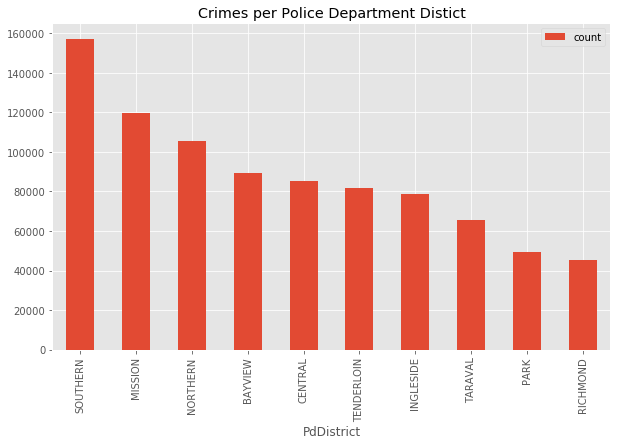

In [13]:
# Doing the heavy lifting in Spark. We could use the 'bar plot' as shown below:

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# Visualizing number of Crimes per Police Department Distict:

#fig = plt.figure()
df.groupBy("PdDistrict").count().select('PdDistrict', 'count').orderBy(col("count").desc()) \
.toPandas() \
.plot.bar(x='PdDistrict', title='Crimes per Police Department Distict')
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,6)
plt.show();

In [10]:
# 2- Check the most committed crime category:

row1 = df.groupBy("Category").count().agg({"count": "max"}).collect()[0]
print(row1)
print(row1["max(count)"])
a = row1["max(count)"]
#df = df.select("Category").groupBy("Category").count().show()#agg({"count": "max"}).show()
#x = df.select('Category').where('count' == 'a')
print(type(a))
print(a)
df.groupBy("Category").count().orderBy(col("count").desc()).show(truncate=False)

Row(max(count)=174900)
174900
<class 'int'>
174900
+----------------------+------+
|Category              |count |
+----------------------+------+
|LARCENY/THEFT         |174900|
|OTHER OFFENSES        |126182|
|NON-CRIMINAL          |92304 |
|ASSAULT               |76876 |
|DRUG/NARCOTIC         |53971 |
|VEHICLE THEFT         |53781 |
|VANDALISM             |44725 |
|WARRANTS              |42214 |
|BURGLARY              |36755 |
|SUSPICIOUS OCC        |31414 |
|MISSING PERSON        |25989 |
|ROBBERY               |23000 |
|FRAUD                 |16679 |
|FORGERY/COUNTERFEITING|10609 |
|SECONDARY CODES       |9985  |
|WEAPON LAWS           |8555  |
|PROSTITUTION          |7484  |
|TRESPASS              |7326  |
|STOLEN PROPERTY       |4540  |
|SEX OFFENSES FORCIBLE |4388  |
+----------------------+------+
only showing top 20 rows



In [11]:
# As observed, "LARCENY/THEFT" is the highest committed crime. So let's monitor it's behavior along the years!

df.withColumn('Year', year(col('Dates'))).select("Category", "Year") \
.where(df.Category == 'LARCENY/THEFT') \
.groupBy("Year").count() \
.orderBy(col("Year").desc()).show()

+----+-----+
|Year|count|
+----+-----+
|2015| 7511|
|2014|18901|
|2013|18152|
|2012|15639|
|2011|13084|
|2010|12214|
|2009|12538|
|2008|12800|
|2007|12760|
|2006|13798|
|2005|12402|
|2004|12111|
|2003|12990|
+----+-----+



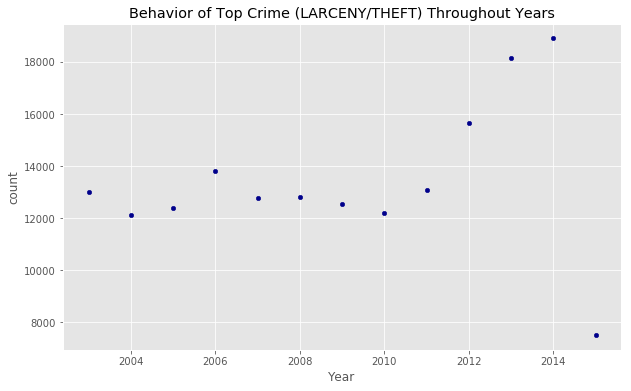

In [14]:

plt.rcParams['figure.figsize'] = (10,6)
df.withColumn('Year', year(col('Dates'))).select("Category", "Year") \
.where(df.Category == 'LARCENY/THEFT') \
.groupBy("Year").count() \
.toPandas() \
.plot.scatter(x='Year',y='count',c='DarkBlue', title='Behavior of Top Crime (LARCENY/THEFT) Throughout Years')


In [15]:
# 3- Check the Year with the highest total number of crimes:

df.withColumn('Year', year(col('Dates'))) \
.groupBy("Year").count() \
.orderBy(col("count").desc()).show(truncate=False)#.limit(5).toPandas()


+----+-----+
|Year|count|
+----+-----+
|2013|75606|
|2014|74766|
|2003|73902|
|2004|73422|
|2012|71731|
|2005|70779|
|2008|70174|
|2006|69909|
|2009|69000|
|2007|68015|
|2011|66619|
|2010|66542|
|2015|27584|
+----+-----+



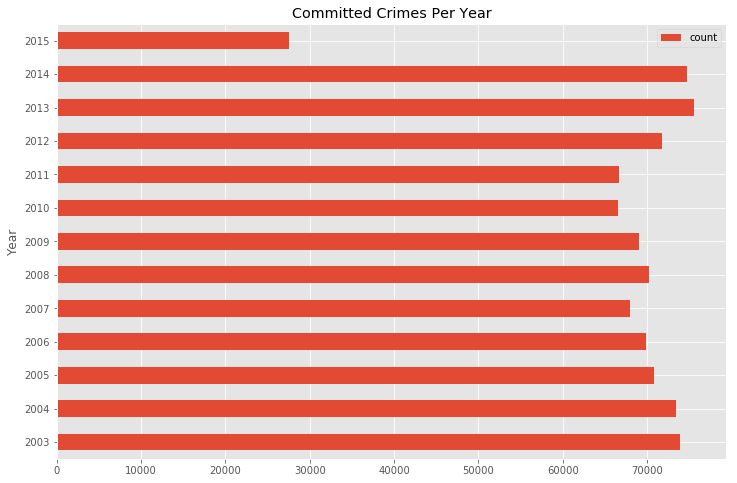

In [16]:
# Plot each year with the corresponding number of crimes.

plt.rcParams['figure.figsize'] = (12,8)
#plt.xlabel('Count of Crimes')
df.withColumn('Year', year(col('Dates'))) \
.groupBy("Year").count() \
.orderBy(col("Year").asc()) \
.toPandas() \
.plot('Year', kind='barh', title='Committed Crimes Per Year')


## Second Step: We will add New Columns to our Training Dataset as below:
#### a- 'Label' column with integer format as mapping to "Category" column to be used afterwords in MLlib classification.
#### b- 'Hour' column
#### c- 'Month' column
#### d- 'Year' column
## Also, will convert longitude and latitude columns (X & Y) to integer instead of String

In [17]:
category_data = df.select("Category").dropDuplicates().toPandas()

In [18]:
category_data['Category_index'] = list(range(len(category_data)))

In [19]:
category_data['Category_index'] = category_data['Category_index'].astype(basestring)

In [20]:
df = df.withColumn("Category_index", col("Category"))

In [21]:
# Transform the format of "Category" to numerical:

df = df.replace(list(category_data.Category), list(category_data.Category_index), 'Category_index')

In [22]:
df = df.select("*", df.Category_index.cast("int").alias("Label")).drop("Category_index")

In [23]:
df = df.withColumn('Year', year(col('Dates')))    # add new 'Year' column

In [24]:
df = df.withColumn('Month', month(col('Dates')))    # add new 'Month' column

In [25]:
df = df.withColumn('Hour', hour(col('Dates')))    # add new 'Hour' column

In [26]:
for X in df.columns:
    df = df.withColumn("X", col('X').cast('integer'))   # convert 'X' column from string to integer

In [27]:
for Y in df.columns:
    df = df.withColumn("Y", col('Y').cast('integer'))   # convert 'Y' column from string to integer

In [28]:
df = df.select("Dates", "Category", "Descript", "DayOfWeek", "PdDistrict", "Resolution", "Address", 
              "X", "Y", "Hour", "Month", "Year", "Label")                  # Re-arranging columns.

In [29]:
df.printSchema()

root
 |-- Dates: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: integer (nullable = true)
 |-- Y: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Label: integer (nullable = true)



In [30]:
print((df.count(), len(df.columns)))
df.limit(5).toPandas()

(878049, 13)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Hour,Month,Year,Label
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122,37,23,5,2015,9
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122,37,23,5,2015,7
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122,37,23,5,2015,7
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122,37,23,5,2015,36
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122,37,23,5,2015,36


## Third Step: Load Test Dataset & Perform Columns Modification for Prediction:

In [31]:
df_test = spark.read.format('csv').load("test.csv", header=True)#,multiLine=True)
df_test.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Dates: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: string (nullable = true)
 |-- Y: string (nullable = true)



In [32]:
df_test = df_test.withColumn('Hour', hour(col('Dates')))

In [33]:
df_test = df_test.withColumn('Month', month(col('Dates')))

In [34]:
df_test = df_test.withColumn('Year', year(col('Dates')))

In [35]:
for X in df_test.columns:
    df_test = df_test.withColumn("X", col('X').cast('integer'))   # convert 'X' column from string to integer

In [36]:
for Y in df_test.columns:
    df_test = df_test.withColumn("Y", col('Y').cast('integer'))   # convert 'X' column from string to integer

In [37]:
df_test.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Dates: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: integer (nullable = true)
 |-- Y: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)



## Fourth Step: Apply the below steps on Train Dataset:
#### a- StringIndexer to Train Data to proceed further in MLlib.
#### b- OneHotEncoder.
#### c- VectorAssembler.
#### d- Scaling.

In [38]:
# Apply StringIndexer to categorical columns: "DayOfWeek" & "PdDistrict"

from pyspark.ml.feature import StringIndexer

dayOfWeekIndexer = StringIndexer(inputCol="DayOfWeek", outputCol="DayOfWeek_index")
pdDistrictIndexer = StringIndexer(inputCol="PdDistrict", outputCol="PdDistrict_index")


In [39]:
# OneHotEncoder on "DayOfWeek" & "PdDistrict" columns:

from pyspark.ml.feature import OneHotEncoder, OneHotEncoderEstimator, OneHotEncoderModel

dayOfWeekEncoder = OneHotEncoder(inputCol="DayOfWeek_index", outputCol="DayOfWeek_Vec")
pdDistrictEncoder = OneHotEncoder(inputCol="PdDistrict_index", outputCol="PdDistrict_Vec")


In [40]:
# VectorAssembler:

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["DayOfWeek_Vec", "PdDistrict_Vec", 
                                      "X", "Y", "Hour", "Month", "Year"],outputCol="features")


In [41]:
# Scaling:

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")#, withStd=True, withMean=False)


## Fifth Step: Select Classifier and Apply Pipeline

In [42]:
# Classification Algorithms:

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier


# Logistic Regression:
# =====================
#lr =   DecisionTreeClassifier(featuresCol="scaled_features", labelCol="Label", maxDepth=3)

# Decision Tree:
# ===============
#lr = LogisticRegression(featuresCol="scaled_features", labelCol="Label", regParam=1)

# Random Forest:
# ==============
lr = RandomForestClassifier(featuresCol="scaled_features", labelCol="Label", numTrees=10)


# Tunable Parameters:
# ===================
# Hyper Parameters for Logistic Regression Classifier: regParam = [0.01, 0.1, 1]
# regParam: The regularization parameter reduces overfitting, which reduces the variance of your estimated regression 
# parameters; however, it does this at the expense of adding bias to your estimate.
# Increasing lambda results in less overfitting but also greater bias.

# Hyper Parameters for Decision Tree Classifier: maxDepth = [3, 5, 7]
# maxDepth: Controls the maximum depth of the tree that will be created. It can also be described as the length of 
# the longest path from the tree root to a leaf. The root node is considered to have a depth of 0.

# Hyper Parameter for Random Forest Classifier: numTrees = [10, 30, 100]
# numtrees: Number of trees in the forest. This parameter is usually the most important setting. 
# In general, the more trees you use the better get the results. However, the improvement decreases as the number of 
# trees increases, i.e. at a certain point the benefit in prediction performance from learning more trees will be lower 
# than the cost in computation time for learning these additional trees.

In [43]:
# Apply pipeline:

from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[dayOfWeekIndexer, pdDistrictIndexer, dayOfWeekEncoder, pdDistrictEncoder, 
                            assembler, scaler, lr])


In [44]:

# Train model. This also runs the whole pipeline.
lr_model = pipeline.fit(df)


In [45]:
lr_results = lr_model.transform(df_test)

In [46]:

#lr_results.limit(5).toPandas()
lr_results.show(5)

+---+-------------------+---------+----------+--------------------+----+---+----+-----+----+---------------+----------------+-------------+--------------+--------------------+--------------------+--------------------+--------------------+----------+
| Id|              Dates|DayOfWeek|PdDistrict|             Address|   X|  Y|Hour|Month|Year|DayOfWeek_index|PdDistrict_index|DayOfWeek_Vec|PdDistrict_Vec|            features|     scaled_features|       rawPrediction|         probability|prediction|
+---+-------------------+---------+----------+--------------------+----+---+----+-----+----+---------------+----------------+-------------+--------------+--------------------+--------------------+--------------------+--------------------+----------+
|  0|2015-05-10 23:59:00|   Sunday|   BAYVIEW|2000 Block of THO...|-122| 37|  23|    5|2015|            6.0|             3.0|    (6,[],[])| (9,[3],[1.0])|(20,[9,15,16,17,1...|(20,[9,15,16,17,1...|[0.13709573420787...|[0.01370957342078...|      36.0|


In [47]:
print(lr_results.printSchema())
lr_results.columns


root
 |-- Id: string (nullable = true)
 |-- Dates: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: integer (nullable = true)
 |-- Y: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- DayOfWeek_index: double (nullable = false)
 |-- PdDistrict_index: double (nullable = false)
 |-- DayOfWeek_Vec: vector (nullable = true)
 |-- PdDistrict_Vec: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

None


['Id',
 'Dates',
 'DayOfWeek',
 'PdDistrict',
 'Address',
 'X',
 'Y',
 'Hour',
 'Month',
 'Year',
 'DayOfWeek_index',
 'PdDistrict_index',
 'DayOfWeek_Vec',
 'PdDistrict_Vec',
 'features',
 'scaled_features',
 'rawPrediction',
 'probability',
 'prediction']

## Sixth Step: Manipulate "probablity" column to fit the requested submission format

In [48]:
# check the contents of 'probability' column:
lr_results.select('probability').show(1, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|probability                                                                                                                                                                          

In [49]:
probability_list = lr_results.select('probability').collect()  # get 'probablity_list' for 'probablity' column

In [50]:
probability_array = np.array(probability_list)        # convert probability_list to array

In [51]:
# Confirm proper conversion from list to array:

probability_array[0:3]

array([[[1.37095734e-02, 5.19633327e-04, 4.79435288e-03, 2.03758639e-03,
         1.45834236e-02, 6.30765978e-04, 4.05439093e-02, 1.56082250e-01,
         2.79581170e-03, 4.34274979e-02, 2.59038665e-03, 1.88457791e-04,
         8.58666963e-03, 1.95279541e-04, 4.99355974e-04, 9.34323047e-02,
         4.31492515e-03, 2.04766017e-04, 1.91656064e-05, 1.31537878e-02,
         9.01489949e-04, 3.76966001e-02, 2.88829599e-02, 5.75417637e-03,
         9.71022956e-04, 3.15397417e-04, 3.19725078e-03, 2.77015862e-03,
         5.32318916e-03, 6.04167302e-02, 4.61615816e-02, 1.80935254e-05,
         6.69143418e-03, 7.46169995e-02, 9.08756486e-02, 5.06046248e-03,
         1.82320485e-01, 2.97666502e-03, 4.27397512e-02]],

       [[1.37095734e-02, 5.19633327e-04, 4.79435288e-03, 2.03758639e-03,
         1.45834236e-02, 6.30765978e-04, 4.05439093e-02, 1.56082250e-01,
         2.79581170e-03, 4.34274979e-02, 2.59038665e-03, 1.88457791e-04,
         8.58666963e-03, 1.95279541e-04, 4.99355974e-04, 9.34323

In [52]:
print(probability_array.shape)
print(len(probability_array))

# So it is observed that "probability_array" is 3D array, accordingly we need to convert it to 2D array or list.

(884262, 1, 39)
884262


In [53]:
# Iterate over "probability_array" and append to the "created_list":

created_list = []
import numpy as np
a = np.zeros(shape=(884262,39))
for i in range(len(probability_array)):
    created_list.append(probability_array[i])


In [54]:
# Confirm proper conversion/append from "probability_array" to "created_list":

print(type(created_list))
print(type(created_list[0]))
print(type(created_list[0][0]))
print(len(created_list))
print(created_list[0][0])


<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
884262
[1.37095734e-02 5.19633327e-04 4.79435288e-03 2.03758639e-03
 1.45834236e-02 6.30765978e-04 4.05439093e-02 1.56082250e-01
 2.79581170e-03 4.34274979e-02 2.59038665e-03 1.88457791e-04
 8.58666963e-03 1.95279541e-04 4.99355974e-04 9.34323047e-02
 4.31492515e-03 2.04766017e-04 1.91656064e-05 1.31537878e-02
 9.01489949e-04 3.76966001e-02 2.88829599e-02 5.75417637e-03
 9.71022956e-04 3.15397417e-04 3.19725078e-03 2.77015862e-03
 5.32318916e-03 6.04167302e-02 4.61615816e-02 1.80935254e-05
 6.69143418e-03 7.46169995e-02 9.08756486e-02 5.06046248e-03
 1.82320485e-01 2.97666502e-03 4.27397512e-02]


In [55]:
# Create dataframe for the "creared_list" of probabilities and map elements according crime categories:

import pandas as pd
probability_df = pd.DataFrame(np.array(created_list).reshape(884262,39), columns= ["ARSON", "ASSAULT", "BAD CHECKS", "BRIBERY", 
                "BURGLARY", "DISORDERLY CONDUCT", "DRIVING UNDER THE INFLUENCE", "DRUG/NARCOTIC", 
                "DRUNKENNESS", "EMBEZZLEMENT", "EXTORTION", "FAMILY OFFENSES", 
                "FORGERY/COUNTERFEITING", "FRAUD", "GAMBLING", "KIDNAPPING", 
                "LARCENY/THEFT", "LIQUOR LAWS", "LOITERING", "MISSING PERSON", 
                "NON-CRIMINAL", "OTHER OFFENSES", "PORNOGRAPHY/OBSCENE MAT", "PROSTITUTION", 
                "RECOVERED VEHICLE", "ROBBERY", "RUNAWAY", "SECONDARY CODES", 
                "SEX OFFENSES FORCIBLE", "SEX OFFENSES NON FORCIBLE", "STOLEN PROPERTY", "SUICIDE", 
                "SUSPICIOUS OCC", "TREA", "TRESPASS", "VANDALISM", 
                "VEHICLE THEFT", "WARRANTS", "WEAPON LAWS"])

In [56]:
probability_df

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.013710,0.000520,0.004794,0.002038,0.014583,0.000631,0.040544,0.156082,0.002796,0.043427,...,0.060417,0.046162,0.000018,0.006691,0.074617,0.090876,0.005060,0.182320,0.002977,0.042740
1,0.013710,0.000520,0.004794,0.002038,0.014583,0.000631,0.040544,0.156082,0.002796,0.043427,...,0.060417,0.046162,0.000018,0.006691,0.074617,0.090876,0.005060,0.182320,0.002977,0.042740
2,0.016885,0.000530,0.004439,0.001908,0.010566,0.000372,0.025185,0.123686,0.002498,0.040039,...,0.057646,0.043458,0.000022,0.006405,0.067039,0.101823,0.005605,0.262242,0.002339,0.046769
3,0.016230,0.000652,0.005211,0.002089,0.013363,0.000607,0.033613,0.147162,0.002950,0.038624,...,0.061982,0.041405,0.000014,0.006195,0.072705,0.100429,0.005184,0.205052,0.003254,0.042193
4,0.016230,0.000652,0.005211,0.002089,0.013363,0.000607,0.033613,0.147162,0.002950,0.038624,...,0.061982,0.041405,0.000014,0.006195,0.072705,0.100429,0.005184,0.205052,0.003254,0.042193
5,0.017816,0.000623,0.004863,0.002247,0.011868,0.000502,0.032873,0.134184,0.002829,0.039399,...,0.059984,0.041865,0.000030,0.006533,0.069151,0.106069,0.005268,0.228455,0.002676,0.043442
6,0.016230,0.000652,0.005211,0.002089,0.013363,0.000607,0.033613,0.147162,0.002950,0.038624,...,0.061982,0.041405,0.000014,0.006195,0.072705,0.100429,0.005184,0.205052,0.003254,0.042193
7,0.016230,0.000652,0.005211,0.002089,0.013363,0.000607,0.033613,0.147162,0.002950,0.038624,...,0.061982,0.041405,0.000014,0.006195,0.072705,0.100429,0.005184,0.205052,0.003254,0.042193
8,0.016105,0.000610,0.005205,0.002835,0.012731,0.000750,0.031408,0.143160,0.003015,0.045538,...,0.055011,0.050411,0.000015,0.006948,0.067289,0.105156,0.005571,0.200756,0.002841,0.038039
9,0.023317,0.000716,0.004495,0.001938,0.009841,0.000399,0.022185,0.115050,0.001938,0.035528,...,0.053307,0.030687,0.000011,0.008657,0.055811,0.122350,0.005877,0.278408,0.002364,0.047686


In [57]:
# Modify "probability_df" to match the required submission file:

probability_df['Id'] = range(0, len(probability_df))    # add "Id" column
cols = ["Id", "ARSON", "ASSAULT", "BAD CHECKS", "BRIBERY", 
                "BURGLARY", "DISORDERLY CONDUCT", "DRIVING UNDER THE INFLUENCE", "DRUG/NARCOTIC", 
                "DRUNKENNESS", "EMBEZZLEMENT", "EXTORTION", "FAMILY OFFENSES", 
                "FORGERY/COUNTERFEITING", "FRAUD", "GAMBLING", "KIDNAPPING", 
                "LARCENY/THEFT", "LIQUOR LAWS", "LOITERING", "MISSING PERSON", 
                "NON-CRIMINAL", "OTHER OFFENSES", "PORNOGRAPHY/OBSCENE MAT", "PROSTITUTION", 
                "RECOVERED VEHICLE", "ROBBERY", "RUNAWAY", "SECONDARY CODES", 
                "SEX OFFENSES FORCIBLE", "SEX OFFENSES NON FORCIBLE", "STOLEN PROPERTY", "SUICIDE", 
                "SUSPICIOUS OCC", "TREA", "TRESPASS", "VANDALISM", 
                "VEHICLE THEFT", "WARRANTS", "WEAPON LAWS"]
probability_df = probability_df[cols]             # re-arrange the orders of columns to fit submission format
probability_df

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0.013710,0.000520,0.004794,0.002038,0.014583,0.000631,0.040544,0.156082,0.002796,...,0.060417,0.046162,0.000018,0.006691,0.074617,0.090876,0.005060,0.182320,0.002977,0.042740
1,1,0.013710,0.000520,0.004794,0.002038,0.014583,0.000631,0.040544,0.156082,0.002796,...,0.060417,0.046162,0.000018,0.006691,0.074617,0.090876,0.005060,0.182320,0.002977,0.042740
2,2,0.016885,0.000530,0.004439,0.001908,0.010566,0.000372,0.025185,0.123686,0.002498,...,0.057646,0.043458,0.000022,0.006405,0.067039,0.101823,0.005605,0.262242,0.002339,0.046769
3,3,0.016230,0.000652,0.005211,0.002089,0.013363,0.000607,0.033613,0.147162,0.002950,...,0.061982,0.041405,0.000014,0.006195,0.072705,0.100429,0.005184,0.205052,0.003254,0.042193
4,4,0.016230,0.000652,0.005211,0.002089,0.013363,0.000607,0.033613,0.147162,0.002950,...,0.061982,0.041405,0.000014,0.006195,0.072705,0.100429,0.005184,0.205052,0.003254,0.042193
5,5,0.017816,0.000623,0.004863,0.002247,0.011868,0.000502,0.032873,0.134184,0.002829,...,0.059984,0.041865,0.000030,0.006533,0.069151,0.106069,0.005268,0.228455,0.002676,0.043442
6,6,0.016230,0.000652,0.005211,0.002089,0.013363,0.000607,0.033613,0.147162,0.002950,...,0.061982,0.041405,0.000014,0.006195,0.072705,0.100429,0.005184,0.205052,0.003254,0.042193
7,7,0.016230,0.000652,0.005211,0.002089,0.013363,0.000607,0.033613,0.147162,0.002950,...,0.061982,0.041405,0.000014,0.006195,0.072705,0.100429,0.005184,0.205052,0.003254,0.042193
8,8,0.016105,0.000610,0.005205,0.002835,0.012731,0.000750,0.031408,0.143160,0.003015,...,0.055011,0.050411,0.000015,0.006948,0.067289,0.105156,0.005571,0.200756,0.002841,0.038039
9,9,0.023317,0.000716,0.004495,0.001938,0.009841,0.000399,0.022185,0.115050,0.001938,...,0.053307,0.030687,0.000011,0.008657,0.055811,0.122350,0.005877,0.278408,0.002364,0.047686


In [58]:
# Write "probability_df" to CSV file:

probability_df.to_csv('RF-numTrees-10-v2.csv', index=False)